In [27]:
import import_ipynb
from circuit_evolution import *

In [28]:
from pyqubo import Spin, Binary

def ising_model_partitioning(number_set):
    """
    Args:
    1) A matrix of the distances (upper triangular)
    2) Vector of the times
    3) Number of bits in the floating-point approximation
    4) If ising = True, the output is an ising model

    Output:
    A linear system problem written as a qubo formulation

    """    
    #set partitioning as a qubo
    qubo = 0
    for k, n in enumerate(number_set):
        qubo += n*(2*Binary("s"+str(k+1)) - 1)
    qubo = qubo**2


    model = qubo.compile()    
    linear, quadratic, offset = model.to_ising()
    
    return linear, quadratic, offset


# problem
numbers = [2,5,1,4,7,4,8,3,4,1] # 0010110001
linear, quadratic, offset = ising_model_partitioning(numbers)

#Hamiltonian construction
num_variables=len(numbers)
H=[[0 for i in range(2**num_variables)] for j in range(2**num_variables) ] #hamiltonian initialize

#quadratic terms from ising model
for key, value in quadratic.items():
    q=QuantumRegister(num_variables,'q')
    circuit = QuantumCircuit(q)
    circuit.z(int(key[0][1:])-1)
    circuit.z(int(key[1][1:])-1)    
    op = qi.Operator(circuit)
    array=op.data
    H+=value*array    

#linear terms from ising model
for key, value in linear.items():
    q=QuantumRegister(num_variables,'q')
    circuit = QuantumCircuit(q)
    circuit.z(int(key[1:])-1)
    op = qi.Operator(circuit)
    array=op.data
    H+=value*array

In [29]:
results = la.eig(H) #Expected minimum energy
print(min(results[0]))

(-200+0j)


In [30]:
func_val=get_min_circuit(H) #gives the value of optimization function at each generation

In [31]:
func_val[-1][0] #gives the value of target function on last generation

array([-199.99994443+0.j])

In [32]:
final_circuit=get_circuit(func_val[-1][1])

In [33]:
qc = QuantumCircuit(num_variables, num_variables)
qc = qc.compose(final_circuit)
qc.measure(range(num_variables), range(num_variables))

counts = execute(qc, backend=simulator, shots=1000).result().get_counts(qc)

In [40]:
counts

{'0101000011': 703, '0101000111': 297}

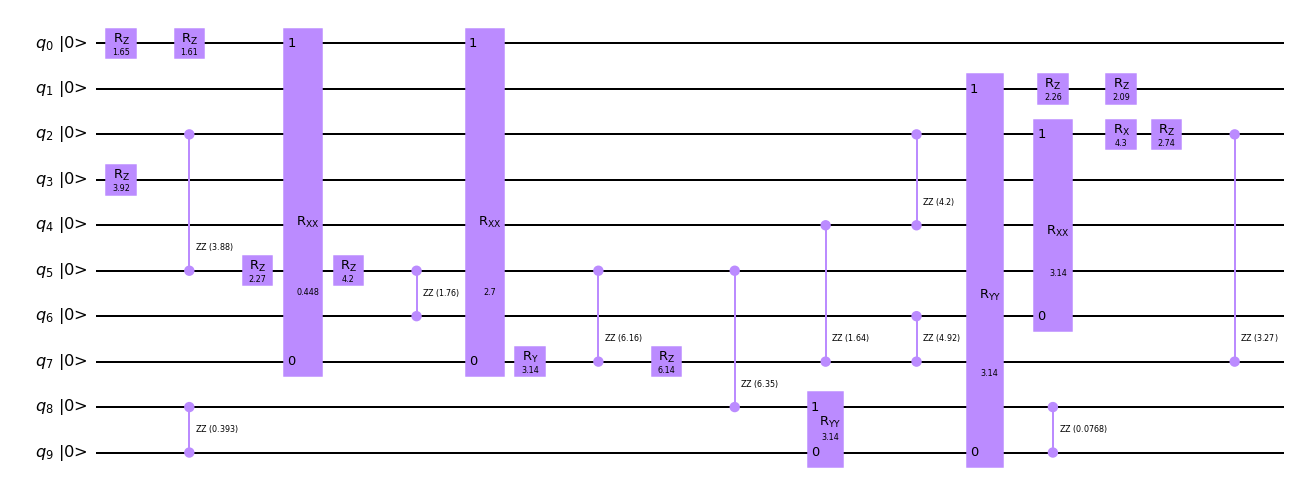

In [34]:
final_circuit=get_circuit(func_val[-1][1])
final_circuit.draw(initial_state=True, output="mpl", fold=-1)

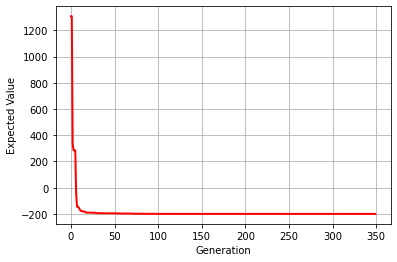

In [72]:
values3=[]
for i in func_val:
    values3.append(i[0].real)
    
plt.plot(values3, linewidth=2, color='red')
plt.xlabel('Generation')
plt.ylabel('Expected Value')
#plt.title('Set')
plt.grid()
plt.savefig('qea_convergence')
plt.show()

In [36]:
def best_cost(counts, numbers):
    """
    Args: counts -> dictionary with final probaility distribution.
    """
    energies=[]; eigenstates=[]
    for key, value in counts.items():
        energies.append(value)
        eigenstates.append(key)

    best_sol_index = energies.index(max(energies))
    best_sol = eigenstates[best_sol_index]

    print("Eigenstate with higher probability: ", best_sol)

    cost = 0
    for i,n in zip(reversed(best_sol), numbers):
        if i=='0':
            cost += n
        elif i=='1':
            cost -= n
        #cost = cost**2

    print("Its cost: ", abs(cost))
    return abs(cost)
    
cost = best_cost(counts=counts, numbers=numbers)

Eigenstate with higher probability:  0101000011
Its cost:  1


In [41]:
sum(numbers)

39

In [37]:
import csv
import pandas as pd

easy_set = pd.read_csv(r'C:/Users/OS-5818/OneDrive/Documentos/Anton/bloot/set-partitioning-qc/data/Set_1000_easy_03.txt')
hard_set = pd.read_csv(r'C:/Users/OS-5818/OneDrive/Documentos/Anton/bloot/set-partitioning-qc/data/Set_1000_Hard_095.txt')
medium_set = pd.read_csv(r'C:/Users/OS-5818/OneDrive/Documentos/Anton/bloot/set-partitioning-qc/data/Set_1000_Medium_05.txt')

In [42]:
def main(dataset):

    """
    
    """

    best_strings=[]; cost_values=[]
    for v in range(dataset.shape[0]):
        print(f"Iteration {v}/1000")
        # problem
        numbers = list(dataset.iloc[v, :])
        linear, quadratic, offset = ising_model_partitioning(numbers)

        #Hamiltonian construction
        num_variables=len(numbers)
        H=[[0 for i in range(2**num_variables)] for j in range(2**num_variables) ] #hamiltonian initialize

        #quadratic terms from ising model
        for key, value in quadratic.items():
            q=QuantumRegister(num_variables,'q')
            circuit = QuantumCircuit(q)
            circuit.z(int(key[0][1:])-1)
            circuit.z(int(key[1][1:])-1)    
            op = qi.Operator(circuit)
            array=op.data
            H+=value*array    

        #linear terms from ising model
        for key, value in linear.items():
            q=QuantumRegister(num_variables,'q')
            circuit = QuantumCircuit(q)
            circuit.z(int(key[1:])-1)
            op = qi.Operator(circuit)
            array=op.data
            H+=value*array

        results = la.eig(H) #Expected minimum energy
        func_val=get_min_circuit(H) #gives the value of optimization function at each generation
        print("Expected minimum energy", min(results[0]), "\t Energy found in last generation: ", func_val[-1][0])
        final_circuit=get_circuit(func_val[-1][1])
        
        qc = QuantumCircuit(num_variables, num_variables)
        qc = qc.compose(final_circuit)
        qc.measure(range(num_variables), range(num_variables))
        counts = execute(qc, backend=simulator, shots=1000).result().get_counts(qc)

        energies=[]; eigenstates=[]
        for key, value in counts.items():
            energies.append(value)
            eigenstates.append(key)

        best_sol_index = energies.index(max(energies))
        best_sol = eigenstates[best_sol_index]

        loss = 0
        for i,n in zip(reversed(best_sol), numbers):
            if i=='0':
                loss += n
            elif i=='1':
                loss -= n

        print("Set summation: ", sum(numbers),"Eigenstate with higher probability: ", best_sol, "Associated cost: ", abs(loss))
        best_strings.append(best_sol)
        cost_values.append(abs(loss))
        #min_en = best_cost(counts=counts)
        #costs.append(min_en)

    return best_strings, cost_values 

    





In [43]:
rest = main(easy_set)

Iteration 0/1000
Expected minimum energy (-290+0j) 	 Energy found in last generation:  [-289.99870215+3.55271368e-15j]
Set summation:  48 Eigenstate with higher probability:  0000010111 Associated cost:  0
Iteration 1/1000
Expected minimum energy (-200+0j) 	 Energy found in last generation:  [-199.99980953+0.j]
Set summation:  39 Eigenstate with higher probability:  1001001011 Associated cost:  1
Iteration 2/1000
Expected minimum energy (-252+0j) 	 Energy found in last generation:  [-251.9933407+0.j]
Set summation:  46 Eigenstate with higher probability:  0100100111 Associated cost:  0
Iteration 3/1000
Expected minimum energy (-172+0j) 	 Energy found in last generation:  [-170.95567624-7.10542736e-15j]
Set summation:  38 Eigenstate with higher probability:  0110001101 Associated cost:  0
Iteration 4/1000
Expected minimum energy (-136+0j) 	 Energy found in last generation:  [-135.99863677-3.55271368e-15j]
Set summation:  30 Eigenstate with higher probability:  0110011000 Associated cost

In [44]:
hard = main(hard_set)

Iteration 0/1000
Expected minimum energy (-857722+0j) 	 Energy found in last generation:  [-857719.45797731+0.j]
Set summation:  2273 Eigenstate with higher probability:  0110000110 Associated cost:  1
Iteration 1/1000
Expected minimum energy (-1587612+0j) 	 Energy found in last generation:  [-1586897.84012275+0.j]
Set summation:  3368 Eigenstate with higher probability:  0010011010 Associated cost:  24
Iteration 2/1000
Expected minimum energy (-1329228+0j) 	 Energy found in last generation:  [-1325193.88546629+0.j]
Set summation:  3357 Eigenstate with higher probability:  1101000110 Associated cost:  5
Iteration 3/1000
Expected minimum energy (-1963112+0j) 	 Energy found in last generation:  [-1962505.1623314+0.j]
Set summation:  3796 Eigenstate with higher probability:  1001100010 Associated cost:  14
Iteration 4/1000
Expected minimum energy (-1610816+0j) 	 Energy found in last generation:  [-1608639.96189333+0.j]
Set summation:  3313 Eigenstate with higher probability:  0011000111 A

(array([431., 502.,  43.,  15.,   5.,   1.,   3.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

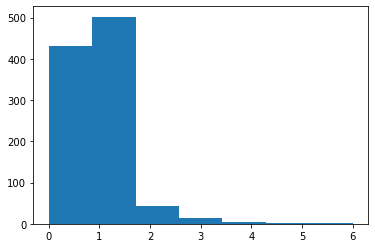

In [61]:
plt.hist(rest[1], 7)

(array([36., 49., 54., 20., 62., 49., 34., 18., 39., 40., 35., 18., 34.,
        28., 24., 11., 19., 22., 18., 12., 14., 20., 15.,  8., 15.,  7.,
         7., 14., 10., 14.,  9., 13., 14.,  6.,  2., 12.,  7.,  7.,  2.,
         4., 10.,  3.,  4.,  5.,  6.,  5.,  3.,  5.,  7.,  6.,  4.,  6.,
         4.,  4.,  6.,  1.,  3.,  0.,  3.,  3.,  4.,  2.,  4.,  1.,  3.,
         1.,  3.,  1.,  1.,  1.,  2.,  0.,  1.,  0.,  1.,  2.,  1.,  3.,
         0.,  3.,  0.,  3.,  2.,  2.,  3.,  1.,  0.,  1.,  1.,  4.,  0.,
         1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  2.,  0.,
         1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,
         0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.

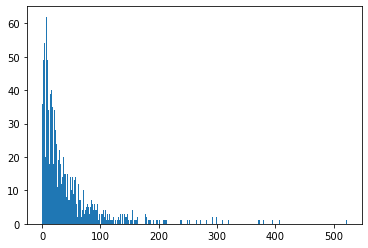

In [63]:
plt.hist(hard[1], 300)

In [67]:
rest[1].count(0)

431

In [70]:
hard[1].count(0)

11